<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using [Folium](https://pypi.org/project/folium/) and [Geopy](https://geopy.readthedocs.io/en/stable/)

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import os

## Data loading

In [2]:
proverbs = pd.read_csv('data/proverbs.csv', index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(10)

,text,place,uri,collector
52466,Το μυαλό σου και μια λύρα και μια κόκκινη νταρ...,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/285136,"Κορύλλος, Χρήστος Π."
76386,Άνεμος και του καπνού,Κάρπαθος,http://hdl.handle.net/20.500.11853/153383,"Μανωλακάκης, Παπαγιάννης"
28524,Λυθήκανη τα γόνατά μ',Σάμος,http://hdl.handle.net/20.500.11853/173367,"Ιωαννίδης, Σωτήρης Ν."
5999,Η μάννα γεννά κ' η μοίρα μοιράζει,Κρήτη,http://hdl.handle.net/20.500.11853/238801,"Βλαστός, Παύλος Γ."
98134,Το πατσατζίδικο το κάμαμε;,Ρόδος,http://hdl.handle.net/20.500.11853/264364,"Παπαχριστόδουλος, Χ."
20093,Άνθρωπος δυο παραδιώ,Αμοργός,http://hdl.handle.net/20.500.11853/143495,"Ιωαννίδης, Εμμανουήλ"
92528,"Η κόττα πίν' νιρό, κι δοξάζ΄ και το Θεό","Ιωάννινα, Χουλιαράδες",http://hdl.handle.net/20.500.11853/181885,"Οικονομίδης, Δημήτριος Β."
2609,Πήγαμε να σκιάζουμε και μας επατάγωσαν,Φιλιππούπολη,http://hdl.handle.net/20.500.11853/264959,"Αποστολίδης, Μύρτιλος Κ."
131639,"Άκουσεν η γρα πορδή, κι' αναρρούφα να την πιή",Κρήτη,http://hdl.handle.net/20.500.11853/249233,anonymous
80869,"Βάζ' κι' η κοσκινού τον άdρα της, με τους πραμ...","Λήμνος, Βάρος",http://hdl.handle.net/20.500.11853/262156,"Μπακιρτζής, Παν."


In [4]:
# removing noisy input (e.g., definitions)
proverbs[proverbs.text.str.contains("=")].sample().text.item()

"Nel maritaggio fatto ner amore, si vive semfire con dolore = Εν τω εξ' έρωτος γάμω η ζωή μετά λύπης άγεται"

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Duplicates exist.

* Exact duplicates may be due to error.

* But there are also duplicated texts, meaning proverbs collected in different places.

In [6]:
# exact duplicates
print(proverbs.duplicated().sum())
proverbs[proverbs.duplicated()].sample()

13875


,text,place,uri,collector
131249,Αν είχε κέρατα θ' αμπρούσε,Ήπειρος,http://hdl.handle.net/20.500.11853/206219,anonymous


In [7]:
# text duplicates
print(proverbs.text.duplicated().sum())
proverbs[proverbs.text.duplicated()].sample(10)

24836


,text,place,uri,collector
122026,Ακόμα δε μπορεί να δέση το βρακί του,Ήπειρος,http://hdl.handle.net/20.500.11853/160188,anonymous
79274,"Όμπτσος θα μετανοιώση, με τσαιρό θέλει το νοιώσει",Κάσος,http://hdl.handle.net/20.500.11853/239276,"Μιχαηλίδης – Νουάρος, Μιχαήλ Γ."
132993,Αηλί π' δεν ξειέται με τα νύχια του,Ήπειρος,http://hdl.handle.net/20.500.11853/289503,anonymous
61006,Χατσή Νικόλα μ' κανακάρ' πχια κουκώνα θα σι πάρ',Αδριανούπολη,http://hdl.handle.net/20.500.11853/204539,"Κωνσταντινίδης, Γ."
121057,"Αλησμονιώνται τα φιλιά, αλησμονιώντ' οι αγάπες...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/159697,anonymous
130506,Dον έπιασε τ' ανεστενάρι,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/243446,anonymous
132184,"Αν δεν βρέξη πρωταπριλιά, γίνεται τα 'πωρικά",Ιωάννινα,http://hdl.handle.net/20.500.11853/249243,anonymous
125389,Αναχούρδικα σαν τας αράπισσας τα μαλλιά,Κρήτη,http://hdl.handle.net/20.500.11853/205260,anonymous
100386,Σαν νύφ' από Δευτέρα,"Θεσπρωτία, Παραμυθιά",http://hdl.handle.net/20.500.11853/288408,"Παυλίδης, Βασίλειος Π."
126554,"Α με ματαϊδής στη βρύση, να με γράψης για δερβίση",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/241944,anonymous


* Places follow the pattern `area, locus, locus, ...`; where each `locus` is a more precisely located place.

* Having a comma inside the pattern can confuse output (for humans)  in pandas when sets are output as strings.

* So we'll substitute `,` by `>`.

In [8]:
proverbs.place = proverbs.place.str.replace('\s*,\s*', '>', regex=True)
proverbs.place

0             Κρήτη>Λασίθι>Κεντρί
1             Κρήτη>Λασίθι>Κεντρί
2             Κρήτη>Λασίθι>Κεντρί
3             Κρήτη>Λασίθι>Κεντρί
4         Κρήτη>Λασίθι>Τουρτούλοι
                   ...           
134488             Θράκη>Σαμακόβι
134489          Μεσσηνία>Φιλιατρά
134490                     Σίφνος
134491                    Ήπειρος
134492               Ηλεία>Πύργος
Name: place, Length: 134106, dtype: object

* Climbing up to the highest-level information per location labelled.

* In `'Κρήτη>Λασίθι>Κεντρί'`, for example, we only keep the first part of the term, using `split` to tokenise.

In [9]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(">")[0])
proverbs.sample(10)

,text,place,uri,collector,area
26899,Τον ατσίμπαλον του κάκου τον βλέπεις,Αμοργός,http://hdl.handle.net/20.500.11853/144061,"Ιωαννίδης, Εμμανουήλ",Αμοργός
36962,Ή μικρός μικρός παντρέψου ή μικρός καλοερέψου,Κάλυμνος,http://hdl.handle.net/20.500.11853/258616,"Καλαβρός, Μιχαήλ",Κάλυμνος
66157,Θα γίνουμε Αιγαίο πέλαγος,Αθήνα,http://hdl.handle.net/20.500.11853/245063,"Λουκάτος, Δημήτριος Σ.",Αθήνα
78439,"Όποιος έχει τα γένια, ας έχη και τα χτένια",Αργολίδα>Ερμιονίδα>Κρανίδι,http://hdl.handle.net/20.500.11853/182068,"Μερεμέτη, Δήμητρα",Αργολίδα
127968,Αγύριστο κεφάλι σαν το μύλο του Κάστρου,Σίφνος,http://hdl.handle.net/20.500.11853/231686,anonymous,Σίφνος
18664,"Απου περιγελάξη ρίγλα, κώμουλο το παθαίνει",Κρήτη>Ρωγδιά,http://hdl.handle.net/20.500.11853/246487,"Ζωγραφάκης, Ιωάννης Ν.",Κρήτη
97223,Στου κουφού την πόρτα όσο θέλεις βρόντα,Νίσυρος>Νικειά,http://hdl.handle.net/20.500.11853/274606,"Παπαμιχαήλ, Άννα Ι.",Νίσυρος
12996,"Πολλού καιρού μελέτημα, μιας ώρας καμωσύνη",Ρόδος,http://hdl.handle.net/20.500.11853/228404,"Δρακίδης, Γεράσιμος Δ.",Ρόδος
26051,"Σε μιάν σταλαματιά νερόν να τον εύρη, θα τον π...",Αμοργός,http://hdl.handle.net/20.500.11853/251956,"Ιωαννίδης, Εμμανουήλ",Αμοργός
92132,"Καινούργιος κόσκινος, που να τον κρεμάσωμε;",Βόρειος Ήπειρος,http://hdl.handle.net/20.500.11853/267804,"Οικονομίδης, Δημήτριος",Βόρειος Ήπειρος


* One more observation regards proverbs with no information about their location 


In [10]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

In [11]:
locations = proverbs.area.unique()
len(locations)

134

* There are 134 unique broad areas registered in the collection. We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [12]:
if not os.path.exists('data/geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα") 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
        else:
            print (loc)

    # fixing some by hand (Cyprus was mislocated too)
    location = geolocator.geocode("Cyprus")
    geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Siteia")
    geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Chania")
    geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Nafpaktia")
    geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Lepenou")
    geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Cappadocia")
    geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Imathia")
    geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Boeotia")
    geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Edirne")
    geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
    geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phthiotis")
    geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Andritsaina")
    geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Dardanelles Strait")
    geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Central Greece")
    geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Areopoli")
    geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Trifylia")
    geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phocis")
    geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("West Mani")
    geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

    pd.DataFrame(geolocs).to_csv("data/geolocs.csv", index=False)

In [13]:
geolocs = pd.read_csv("data/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
lat,35.308495,36.971401,41.091071,39.365088,37.957433,38.706573,38.069275,38.494172,40.686029,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
lon,24.463342,24.708110,23.549803,23.135561,23.710852,20.641709,21.872730,23.911084,23.693390,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


* Now we update the corpus with the mined information.

In [14]:
geolocs = geolocs.to_dict()
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

## The anonymous collector
* Not all proverbs were collected by named individuals.

In [15]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


## Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [16]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [17]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 `area`s.

In [18]:
unique_areas = named[named.text.duplicated()].area.unique()
print(unique_areas)
unique_areas.shape[0]

['Εύβοια' 'Λέσβος' 'Ήπειρος' 'Ρούμελη' 'Κοζάνη' 'Αρκαδία' 'Ίμβρος'
 'Φιλιππούπολη' 'Αττική' 'Πόντος' 'Δαρδανέλλια (Ελλήσποντος)' 'Θράκη'
 'Μακεδονία' 'Κεφαλληνία' 'Μήλος' 'Χίος' 'Μικρά Ασία' 'Κρήτη' 'Κίμωλος'
 'Άνδρος' 'Λέρος' 'Ρόδος' 'Κύπρος' 'Άρτα' 'Πρέβεζα' 'Παξοί' 'Καρδίτσα'
 'Άδηλου τόπου' 'Καστελλόριζο (Μεγίστη)' 'Αθήνα' 'Μεσσηνία' 'Λακωνία'
 'Σίφνος' 'Ηλεία' 'Σύμη' 'Θήρα (Σαντορίνη)' 'Κως' 'Σμύρνη' 'Κάλυμνος'
 'Νάξος' 'Αδριανούπολη' 'Ευρυτανία' 'Κέρκυρα' 'Αμοργός' 'Θεσπρωτία'
 'Σάμος' 'Καστοριά' 'Βοιωτία' 'Επτάνησος' 'Νίσυρος' 'Αχαΐα' 'Κορινθία'
 'Τήλος' 'Πέλλα' 'Λάρισα' 'Κύθηρα' 'Ιωάννινα' 'Ημαθία' 'Φωκίδα'
 'Πελοπόννησος' 'Σύρος' 'Μάνη' 'Σκύρος' 'Αιτωλία' 'Κύθνος' 'Τήνος' 'Κέα'
 'Άγιον Όρος' 'Πάρος' 'Θεσσαλία' 'Μάλγαρα' 'Ανατολική Κρήτη' 'Μαγνησία'
 'Σέριφος' 'Ιθάκη' 'Λευκάδα' 'Αργολίδα' 'Καππαδοκία' 'Ακαρνανία'
 'Ζάκυνθος' 'Ικαρία' 'Φθιώτιδα' 'Τρίκαλα' 'Κάρπαθος' 'Λήμνος' 'Μπλάτση'
 'Κάσος' 'Αιτωλοακαρνανία' 'Ανάφη' 'Κόρινθος' 'Στερεά Ελλάδα' 'Θάσος'
 'Αστυπάλαια' 'Βόρειος Ήπ

104

* We group by `text` the `named` duplicates , to get duplicates using items by named collectors.

In [19]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.agg(set)})
duplicates["place_num"] = duplicates.place.agg(len)
duplicates.sort_values(by="place_num", ascending=False)[:10]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία>Σινώπη, Κρήτη>Λασίθι>Άγιος Γεώργιο...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αμοργός, Αργολίδα>Ερμιονίδα>Κρανίδι, Κοζάνη>Β...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Θράκη>Σαράντα Εκκλησίες, Θράκη>Περιστερά, Φιλ...",27
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Φιλιππούπολη, Κοζάνη>Βόϊο>Διαλεκτό, Κρήτη>Ρέθ...",26
"Θέρος, τρύγος, πόλεμος","{Κορινθία>Τρίκαλα, Πέλλα>Γιαννιτσα>Παλαίφυτο, ...",22
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Κορινθία>Τρίκαλα, Ρόδος, Καρδίτσα, Νίσυρος>Μα...",20
Το γουδί το γουδοχέρι,"{Σύμη, Λακωνία>Σπάρτη, Ήπειρος>Κόνιτσα>Βούρμπι...",19
Το γοργόν και χάριν έχει,"{Αμοργός, Δαρδανέλλια (Ελλήσποντος), Εύβοια>Κύ...",17
Αλλού τ' όνειρο κι' αλλού το θάμα,"{Μήλος, Μάνη, Μικρά Ασία>Βιθυνία>Κατιρλί, Εύβο...",17


* As previously, we'll get the broader location, which we'll call `area`.

In [20]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(">")[0] for i in x})
duplicates["area_num"] = duplicates.area.agg(len)
duplicates.sort_values(by="area_num", ascending=False)[:10]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία>Σινώπη, Κρήτη>Λασίθι>Άγιος Γεώργιο...",45,"{Ημαθία, Φιλιππούπολη, Καστοριά, Νάξος, Ρούμελ...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Φιλιππούπολη, Κοζάνη>Βόϊο>Διαλεκτό, Κρήτη>Ρέθ...",26,"{Φιλιππούπολη, Φωκίδα, Καστοριά, Νάξος, Ρούμελ...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αμοργός, Αργολίδα>Ερμιονίδα>Κρανίδι, Κοζάνη>Β...",28,"{Αμοργός, Δαρδανέλλια (Ελλήσποντος), Τήλος, Μα...",18
Θεωρία επισκόπου και καρδιά μυλωνά,"{Θράκη>Σαράντα Εκκλησίες, Θράκη>Περιστερά, Φιλ...",27,"{Δαρδανέλλια (Ελλήσποντος), Κύπρος, Τήλος, Ιωά...",17
Το γοργόν και χάριν έχει,"{Αμοργός, Δαρδανέλλια (Ελλήσποντος), Εύβοια>Κύ...",17,"{Αμοργός, Δαρδανέλλια (Ελλήσποντος), Ρόδος, Κρ...",16
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Κορινθία>Τρίκαλα, Ρόδος, Καρδίτσα, Νίσυρος>Μα...",20,"{Νίσυρος, Μακεδονία, Λακωνία, Ρόδος, Κρήτη, Αχ...",16
"Θέρος, τρύγος, πόλεμος","{Κορινθία>Τρίκαλα, Πέλλα>Γιαννιτσα>Παλαίφυτο, ...",22,"{Πέλλα, Επτάνησος, Μακεδονία, Τριφυλία, Αχαΐα,...",16
Το γουδί το γουδοχέρι,"{Σύμη, Λακωνία>Σπάρτη, Ήπειρος>Κόνιτσα>Βούρμπι...",19,"{Θήρα (Σαντορίνη), Λακωνία, Τριφυλία, Πόντος, ...",16
Καλομελέτα κι έρχεται,"{Ιωάννινα>Μέγα Περιστέρι, Μικρά Ασία>Κυδωνία, ...",17,"{Ιωάννινα, Μακεδονία, Ρόδος, Κρήτη, Καστελλόρι...",15


In [21]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [22]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [23]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample(10)

,place,place_num,area,area_num,latlon
text,,,,,
Μη στάξη και μη βρέξη,"{Μακεδονία, Αρκαδία>Γορτυνία, Ήπειρος}",3,"{Μακεδονία, Ήπειρος, Αρκαδία}",3,"[(40.6860291, 23.6933899), (37.9574332, 23.710..."
Μάρτης γδάρτης και κακός παλουκοκαύτης,"{Ρόδος, Λάρισα>Ελασσόνα>Σαραντάπορο, Πρέβεζα>Π...",5,"{Ρόδος, Θράκη, Λάρισα, Κοζάνη, Πρέβεζα}",5,"[(36.17262995, 27.919418145633188), (40.846424..."
Βρήκα πεθερά κλανιάρα αναθεμα κι αν δεν την διάβω,"{Θεσσαλία, Λακωνία}",2,"{Λακωνία, Θεσσαλία}",2,"[(36.76027945, 22.79046431389755), (39.5594194..."
Φρέσκα χρόνια περσινα μαρούλια,"{Ανάφη, Λακωνία}",2,"{Ανάφη, Λακωνία}",2,"[(36.37344365, 25.77730028296469), (36.7602794..."
Στου κασιδιάρη το κεφάλι όλοι μπαρμπέρηδες γίνονται,"{Κοζάνη>Βόϊο>Ζώνη, Λακωνία}",2,"{Κοζάνη, Λακωνία}",2,"[(40.3007259, 21.7883119), (36.76027945, 22.79..."
Τα ξέρουν ςτο παζάρι τάχα το ΄ξερουν και ςτο σπίτι;,"{Ζάκυνθος, Λακωνία}",2,"{Ζάκυνθος, Λακωνία}",2,"[(37.78913845, 20.790089567090195), (36.760279..."
"Κούτου μάνα, κούτου παιδί","{Κρήτη>Λασίθι>Άγιος Κωνσταντίνος, Ρόδος}",2,"{Κρήτη, Ρόδος}",2,"[(35.3084952, 24.46334231842296), (36.17262995..."
Κάτσε στραβά και κρίνε ίσα,"{Αμοργός, Ιθάκη}",2,"{Αμοργός, Ιθάκη}",2,"[(36.85252415, 25.89848696771565), (38.4018960..."
"Μη μου σπάσης την κασελα, γιατί σου σπάζω το κιούπι","{Αρκαδία>Κυνουρία, Λακωνία}",2,"{Αρκαδία, Λακωνία}",2,"[(38.0368583, 23.6689264), (36.76027945, 22.79..."


In [24]:
# saving
duplicates.to_csv("data/duplicates_geolocated.csv")

* To visualise the dataframe, we use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note: outliers exist, e.g., Chiesa della Madona delle Neve

In [25]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html")
m

* Finding the number of areas sharing proverbs with crowded Athens.

In [ ]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


## Single-placed proverbs

In [ ]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


,text,place,uri,collector,area,lat,lon
12781,Ο μύλος θέλει μυλωνά και το καράβι ναύτη και τ...,Ρόδος,http://hdl.handle.net/20.500.11853/284191,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418
108506,Από τον Άουστο αρχίζει πια ο χειμώνας,Κίμωλος,http://hdl.handle.net/20.500.11853/158085,"Σπυριδάκης, Γεώργιος Κ.",Κίμωλος,36.809258,24.556068
105214,Μ' πουνεί του δόντ',Σκιάθος,http://hdl.handle.net/20.500.11853/177096,"Ρήγας, Γ.",Σκιάθος,39.169298,23.455251


* We'll move aside single-placed proberbs from an unknown place.

In [28]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
73950,Τον έχει να μη στάξη και τον βρέξη,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/152797,"Μανασσείδης, Συμεών Α.",Άδηλου τόπου,NaN,NaN
89426,Του μπήκε καρφί στο μάτι,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/280370,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
84732,Κάλλια μαύρα μούτσουνα παρά μαύρη καρδιά,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/270266,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN


* We'll work with the rest.

In [29]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


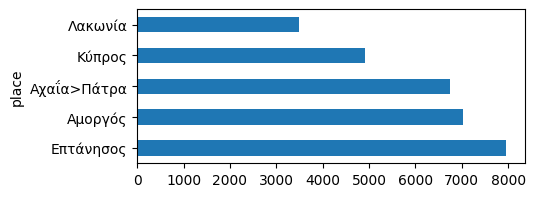

In [30]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(5,2));

* Visualising the places along with the number of proverbs collected in each.

In [31]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(">")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [32]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


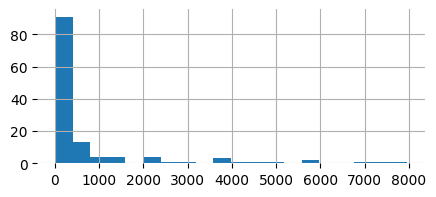

In [33]:
placed_pd.length.hist(bins=20, figsize=(5,2));
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [34]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters.

In [35]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus.

In [36]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TFILF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across locations (location > document) are more important (ILF). 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [39]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [40]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ,0.0,0.0,0.0,0.0,0.0,0.0,0.015971,0.0,0.0,0.0,...,0.0,0.661621,0.0,0.0,0.0,0.0,0.015777,0.0,0.0,0.0
τζαι,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.360815,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
τζαί,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.343215,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


* Computing a lexicon with the terms with the highest TFIDF value per area

In [41]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['τουν', 'ου', 'τούν'],
 'Αιτωλία': ['ου', 'τουν', 'είνι'],
 'Αμοργός': ['λωλός', 'γυρεύγει', 'μηδέ'],
 'Ανατολική Θράκη': ['πάγη', 'γίνουνται', 'βάσανα'],
 'Αρκαδία': ['πόδια', 'ρε', 'θες'],
 'Αχαΐα': ['ήρθε', 'ήναι', 'στους'],
 'Επτάνησος': ['ναν', 'τσου', 'τονε'],
 'Εύβοια': ['τσαί', 'τσαι', 'σι'],
 'Θεσπρωτία': ['δρόμο', 'αλλά', 'γομάρι'],
 'Θράκη': ['πε', 'δι', 'τς'],
 'Ιωάννινα': ['μι', 'τουν', 'ου'],
 'Κάρπαθος': ['τσαί', 'τσαι', 'μήε'],
 'Κεφαλληνία': ['τσου', 'τση', 'ναν'],
 'Κρήτη': ['ντου', 'οντέ', 'απου'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'είνι'],
 'Λακωνία': ['γίνου', 'μαλώνουν', 'δική'],
 'Μακεδονία': ['τουν', 'ου', 'μι'],
 'Μικρά Ασία': ['κη', 'τουν', 'κή'],
 'Νάξος': ['τζη', 'ια', 'ίνεται'],
 'Πόντος': ['σο', 'ατ', 'σην'],
 'Ρόδος': ['λωλλός', 'ηύραν', 'γρηά'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms per location on a map (clickable pins)

In [42]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html')
m

In [43]:
geotfidf.to_csv("data/geotfidf.csv", index=False)
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,τουν,ου,λωλός,πάγη,πόδια,ήρθε,ναν,τσαί,δρόμο,πε,...,ντου,τζ,τσι,γίνου,τουν,κη,τζη,σο,λωλλός,τσαί
1,ου,τουν,γυρεύγει,γίνουνται,ρε,ήναι,τσου,τσαι,αλλά,δι,...,οντέ,τζαι,τουν,μαλώνουν,ου,τουν,ια,ατ,ηύραν,τσαι
2,τούν,είνι,μηδέ,βάσανα,θες,στους,τονε,σι,γομάρι,τς,...,απου,τζαί,είνι,δική,μι,κή,ίνεται,σην,γρηά,έναι


In [44]:
# using English names and printing a latex table
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & τουν & ου & τούν \\
Etolia & ου & τουν & είνι \\
Amorgos & λωλός & γυρεύγει & μηδέ \\
East Thrace & πάγη & γίνουνται & βάσανα \\
Arcadia & πόδια & ρε & θες \\
Achaia & ήρθε & ήναι & στους \\
Eptanisos & ναν & τσου & τονε \\
Eyvoia & τσαί & τσαι & σι \\
Thesprotia & δρόμο & αλλά & γομάρι \\
Thrace & πε & δι & τς \\
Ioannina & μι & τουν & ου \\
Karpathos & τσαί & τσαι & μήε \\
Kefalinia & τσου & τση & ναν \\
Crete & ντου & οντέ & απου \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & είνι \\
Laconia & γίνου & μαλώνουν & δική \\
Macedonia & τουν & ου & μι \\
Asia Minor & κη & τουν & κή \\
Naxos & τζη & ια & ίνεται \\
Pontos & σο & ατ & σην \\
Rodos & λωλλός & ηύραν & γρηά \\
Skyros & τσαί & τσαι & έναι \\


In [45]:
balanced_corpus.to_csv('balanced_corpus.csv', index=False)